In [1]:
# !nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-7d172190-7fcb-4ece-1bf8-ca41bd865b58)


In [59]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Flatten, Conv2D, BatchNormalization, ReLU, Reshape, Conv2DTranspose, Lambda, Multiply, Add, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import GlorotNormal
from tensorflow.keras.activations import selu, sigmoid

import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm
import os
import zipfile
import urllib.request
import random
from IPython import display
from IPython.display import Image as IpyImage
import imageio
import cv2
import math

np.random.seed(1)
tf.random.set_seed(1)

In [3]:
path = 'input/'
if not os.path.exists(path):
    os.mkdir(path)
    # download the zipped dataset to the data directory
    data_url = "https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Resources/anime-faces.zip"
    data_file_name = "animefaces.zip"
    urllib.request.urlretrieve(data_url, data_file_name)
    # extract the zip file
    zip_ref = zipfile.ZipFile(data_file_name, 'r')
    zip_ref.extractall(path)
    zip_ref.close()

In [2]:
image_dir = 'input/images/'
image_file_list = os.listdir(image_dir)
image_paths = [os.path.join(image_dir, fname) for fname in image_file_list]

random.shuffle(image_paths)

# split the paths list into to training (95%) and validation sets(5%).
paths_len = len(image_paths)
train_paths_len = int(paths_len * 0.95)

train_paths = image_paths[:train_paths_len]
val_paths = image_paths[train_paths_len:]

In [3]:
IMAGE_SIZE = 64

def map_image(image_filename):
    '''preprocesses the images'''
    img_raw = tf.io.read_file(image_filename)
    image = tf.image.decode_jpeg(img_raw)

    image = tf.cast(image, dtype=tf.float32)
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    image = image / 255.0  
    image = tf.reshape(image, shape=(IMAGE_SIZE, IMAGE_SIZE, 3,))

    return image

In [4]:
BATCH_SIZE = 128

training_dataset = tf.data.Dataset.from_tensor_slices((train_paths))
training_dataset = training_dataset.map(map_image)
training_dataset = training_dataset.shuffle(1000).batch(BATCH_SIZE)

validation_dataset = tf.data.Dataset.from_tensor_slices((val_paths))
validation_dataset = validation_dataset.map(map_image)
validation_dataset = validation_dataset.batch(BATCH_SIZE)

print(f'number of batches in the training set: {len(training_dataset)}')
print(f'number of batches in the validation set: {len(validation_dataset)}')

number of batches in the training set: 472
number of batches in the validation set: 25


In [5]:
def display_faces(dataset, size=9):
    '''Takes a sample from a dataset batch and plots it in a grid.'''
    dataset = dataset.unbatch().take(size)
    n_cols = 3
    n_rows = size//n_cols + 1
    plt.figure(figsize=(5, 5))
    i = 0
    for image in dataset:
        i += 1
        disp_img = np.reshape(image, (64,64,3))
        plt.subplot(n_rows, n_cols, i)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(disp_img)


def display_one_row(disp_images, offset, shape=(28, 28)):
    '''Displays a row of images.'''
    for idx, image in enumerate(disp_images):
        plt.subplot(3, 10, offset + idx + 1)
        plt.xticks([])
        plt.yticks([])
        image = np.reshape(image, shape)
        plt.imshow(image)


def display_results(disp_input_images, disp_predicted):
    '''Displays input and predicted images.'''
    plt.figure(figsize=(15, 5))
    display_one_row(disp_input_images, 0, shape=(IMAGE_SIZE,IMAGE_SIZE,3))
    display_one_row(disp_predicted, 20, shape=(IMAGE_SIZE,IMAGE_SIZE,3))

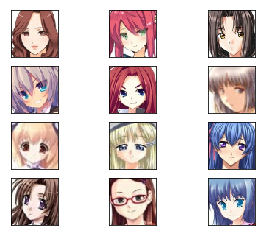

In [6]:
display_faces(validation_dataset, size=12)

In [110]:
tf.keras.backend.clear_session()

latent_dim = 512

#Initializers
w_init = tf.random_normal_initializer(stddev=0.02)
gamma_init = tf.random_normal_initializer(1., 0.02)
conv_init = GlorotNormal(seed=10)

# Encoder layers
encoder_in = Input(shape=(64,64,3))

x = Conv2D(filters=64/2, kernel_size=5, strides=1, padding='same', name="encode_conv1", kernel_initializer=conv_init)(encoder_in)
x = BatchNormalization(gamma_initializer=gamma_init)(x)
x = ReLU()(x)

x = Conv2D(filters=64, kernel_size=5, strides=2, padding='same', name="encode_conv2", kernel_initializer=conv_init)(x)
x = BatchNormalization(gamma_initializer=gamma_init)(x)
x = ReLU()(x)

x = Conv2D(filters=64*2, kernel_size=5, strides=2, padding='same', name="encode_conv3", kernel_initializer=conv_init)(x)
x = BatchNormalization(gamma_initializer=gamma_init)(x)
x = ReLU()(x)

x = Conv2D(filters=64*4, kernel_size=5, strides=2, padding='same', name="encode_conv4", kernel_initializer=conv_init)(x)
x = BatchNormalization(gamma_initializer=gamma_init)(x)
x = ReLU()(x)

x = Conv2D(filters=64*8, kernel_size=5, strides=2, padding='same', name="encode_conv5", kernel_initializer=conv_init)(x)
x = BatchNormalization(gamma_initializer=gamma_init)(x)
x = ReLU()(x)

x = Flatten(name="encoder_flatten")(x)

x = Dense(1024, name="encoder_dense", kernel_initializer=w_init)(x)  
x = BatchNormalization(gamma_initializer=gamma_init)(x)
encoder_out = selu(x)

# Sampling layer
mu = Dense(latent_dim, name='latent_mu', kernel_initializer=w_init)(encoder_out)
log_var = Dense(latent_dim, name ='latent_log_var', kernel_initializer=w_init)(encoder_out)

epsilon = tf.keras.backend.random_normal(shape=(tf.shape(mu)[0], tf.shape(mu)[1]))

sigma = tf.exp(0.5 * log_var)

z_eps = Multiply()([sigma, epsilon])

z = Add()([mu, z_eps])

encoder = Model(encoder_in, outputs=[mu, log_var, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
encode_conv1 (Conv2D)           (None, 64, 64, 32)   2432        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 32)   128         encode_conv1[0][0]               
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 64, 64, 32)   0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [111]:
tf.keras.backend.clear_session()

decoder = Sequential(name='decoder')

decoder.add(Dense(1024, name="decode_dense1", input_shape=(latent_dim, )))
decoder.add(BatchNormalization(gamma_initializer=gamma_init))
decoder.add(Activation('selu'))

decoder.add(Dense(8192, name="decode_dense2"))
decoder.add(BatchNormalization(gamma_initializer=gamma_init))
decoder.add(Activation('selu'))

decoder.add(Reshape((4, 4, 512), name="decode_reshape"))

decoder.add(Conv2DTranspose(filters=64*4, kernel_size=5, strides=2, padding='same', name="decode_conv2d_1", kernel_initializer=conv_init))
decoder.add(BatchNormalization(gamma_initializer=gamma_init))
decoder.add(Activation('selu'))

decoder.add(Conv2DTranspose(filters=64*2, kernel_size=5, strides=2, padding='same', name="decode_conv2d_2", kernel_initializer=conv_init))
decoder.add(BatchNormalization(gamma_initializer=gamma_init))
decoder.add(Activation('selu'))

decoder.add(Conv2DTranspose(filters=64, kernel_size=5, strides=2, padding='same', name="decode_conv2d_3", kernel_initializer=conv_init))
decoder.add(BatchNormalization(gamma_initializer=gamma_init))
decoder.add(Activation('selu'))

decoder.add(Conv2DTranspose(filters=64/2, kernel_size=5, strides=2, padding='same', name="decode_conv2d_4", kernel_initializer=conv_init))
decoder.add(BatchNormalization(gamma_initializer=gamma_init))
decoder.add(Activation('selu'))

decoder.add(Conv2DTranspose(filters=3, kernel_size=5, strides=1, padding='same', activation='sigmoid', name="decode_final", kernel_initializer=conv_init))
decoder.add(BatchNormalization(gamma_initializer=gamma_init))
decoder.add(Activation('sigmoid'))

decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decode_dense1 (Dense)        (None, 1024)              525312    
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
activation (Activation)      (None, 1024)              0         
_________________________________________________________________
decode_dense2 (Dense)        (None, 8192)              8396800   
_________________________________________________________________
batch_normalization_1 (Batch (None, 8192)              32768     
_________________________________________________________________
activation_1 (Activation)    (None, 8192)              0         
_________________________________________________________________
decode_reshape (Reshape)     (None, 4, 4, 512)         0   

In [9]:
def reconstruction_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

def kl_loss(mu, log_var):
    kl_loss = - 0.5 * tf.reduce_mean(1 + log_var - tf.square(mu) - tf.exp(log_var))
    return kl_loss

def vae_loss(y_true, y_pred, mu, log_var):
    return reconstruction_loss(y_true, y_pred) + (1/ (64*64)) * kl_loss(mu, log_var)

In [112]:
tf.keras.backend.clear_session()

def VariationalAutoEncoder(encoder_in, encoder=encoder, decoder=decoder):
    
    mu, log_var, z = encoder(encoder_in)
    reconstructed = decoder(z)
    vae = Model(encoder_in, reconstructed, name='VAE')
    
    loss = kl_loss(mu, log_var)
    vae.add_loss(loss)
    
    
    return vae

vae = VariationalAutoEncoder(encoder_in, encoder, decoder)
vae.summary()

Model: "VAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
encoder (Functional)            [(None, 512), (None, 13802688    input_1[0][0]                    
__________________________________________________________________________________________________
decoder (Sequential)            (None, 64, 64, 3)    13315791    encoder[0][2]                    
__________________________________________________________________________________________________
tf.__operators__.add (TFOpLambd (None, 512)          0           encoder[0][1]                    
________________________________________________________________________________________________

In [108]:
def generate_and_save_images(model, epoch, step, test_input):
    """Helper function to plot our 16 images
    """
#     epoch = epoch+150
    predictions = model.predict(test_input)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        img = predictions[i, :, :, :] * 255
        img = img.astype('int32')
        plt.imshow(img)
        plt.axis('off')

    out_path = 'output/'
    if not os.path.exists(out_path):
        os.mkdir(out_path)
    
    fig.suptitle("epoch: {}, step: {}".format(epoch, step))
    plt.savefig(out_path+'image_at_epoch_{:04d}_step{:04d}.png'.format(epoch, step))
    plt.show()

In [ ]:
# def exp_decay(epoch):
#    initial_lrate = 0.005
#    k = 0.1
#    lrate = initial_lrate * exp(-k*t)
#    return lrate
# # lrate = LearningRateScheduler(exp_decay)

# def set_learning_rate(epoch):
#     if epoch > 180:
#         optimizer.lr = 0.5e-6
#     elif epoch > 160:
#         optimizer.lr = 1e-6
#     elif epoch > 120:
#         optimizer.lr = 1e-5
#     elif epoch > 3:
#         optimizer.lr = 1e-4

# optimizer = Adam(learning_rate = LearningRateScheduler(exp_decay))



In [94]:
def lr_time_based_decay(initial_lr, drop_rate, epoch, epochs_drop):
    lr = initial_lr * drop_rate ** math.floor(epoch / epochs_drop)
    return lr    

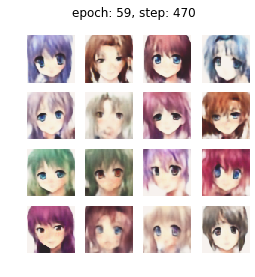

Epoch: 59 step: 470 VAE loss = 0.0141365025 - RMSE loss = 0.011434714 - KL = 0.27017885
Epoch: 59 step: 471 VAE loss = 0.01419535 - RMSE loss = 0.011492885 - KL = 0.2702465


In [113]:
epochs = 60

random_vector_for_generation = tf.random.normal(shape=[16, latent_dim])
generate_and_save_images(decoder, 0, 0, random_vector_for_generation)

mse_vector = []
KL_vector = []


for epoch in range(epochs):
    print('Start of epoch %d' % (epoch,))
    
    optimizer = Adam(learning_rate=lr_time_based_decay(0.0005, 0.5, epoch, 15.0))
    
    # Iterate over the batches of the dataset.
    for step, x_batch_train in enumerate(training_dataset):
        with tf.GradientTape() as tape:

            reconstructed = vae(x_batch_train)
            y_true = tf.reshape(x_batch_train, shape=[-1])
            y_pred = tf.reshape(reconstructed, shape=[-1])
            
            mse_loss = reconstruction_loss(y_true, y_pred)
            mse_vector.append(mse_loss.numpy())
            
            KL_loss = sum(vae.losses)
            KL_vector.append(KL_loss.numpy())

            train_loss = 0.01 * KL_loss + mse_loss
            
        grads =  tape.gradient(train_loss, vae.trainable_variables)
        optimizer.apply_gradients(zip(grads, vae.trainable_variables))


        if step % 10 == 0:
            display.clear_output(wait=False)
            generate_and_save_images(decoder, epoch, step, random_vector_for_generation)
            
        print('Epoch: %s step: %s VAE loss = %s - RMSE loss = %s - KL = %s' % (epoch, step, train_loss.numpy(), mse_loss.numpy(), KL_loss.numpy()))

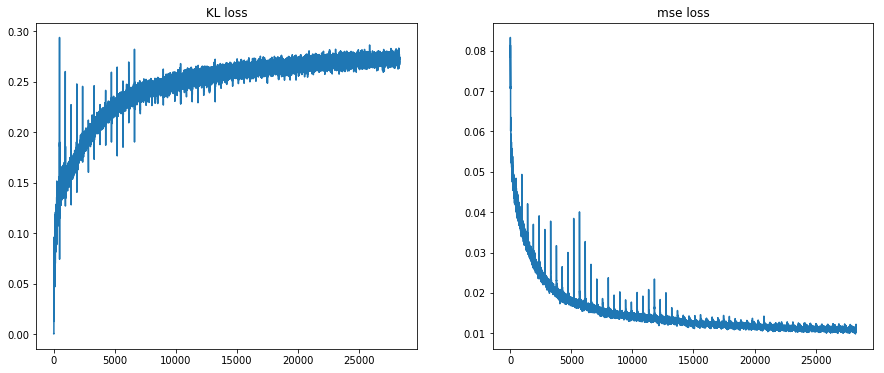

In [118]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
ax[0].plot(KL_vector)
ax[0].set_title('KL loss')
ax[1].plot(mse_vector)
ax[1].set_title('mse loss');

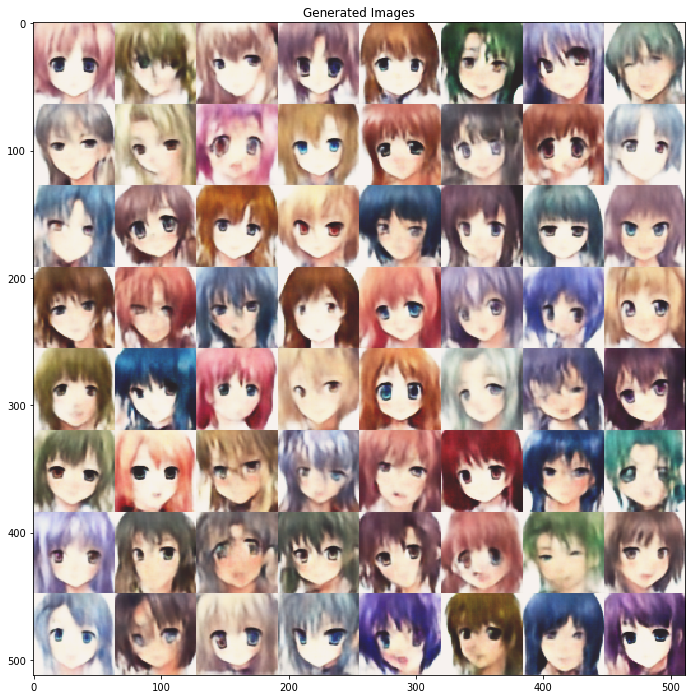

In [119]:
def plot_images(rows, cols, images, title):
    '''Displays images in a grid.'''
    grid = np.zeros(shape=(rows*64, cols*64, 3))
    for row in range(rows):
        for col in range(cols):
            grid[row*64:(row+1)*64, col*64:(col+1)*64, :] = images[row*cols + col]

    plt.figure(figsize=(12,12))       
    plt.imshow(grid)
    plt.title(title)
    plt.show()

# initialize random inputs
test_vector_for_generation = tf.random.normal(shape=[64, latent_dim])

# get predictions from the decoder model
predictions= decoder.predict(test_vector_for_generation)

# plot the predictions
plot_images(8,8,predictions,'Generated Images')

In [126]:
imgs = os.listdir('output')
imgs.sort()
imgs = imgs[:100]
imgs = [cv2.imread('output/' + i) for i in imgs]
imgs = [cv2.cvtColor(i, cv2.COLOR_BGR2RGB) for i in imgs]
imageio.mimsave('anime.gif', imgs, fps=25)

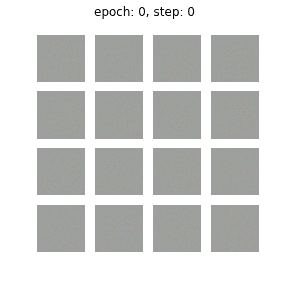

In [127]:
path="anime.gif"

with open(path,'rb') as f:
    display.display(IpyImage(data=f.read(), format='png'))